## 1 Modeling Volatility and VaR

In [204]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from arch import arch_model
from arch.univariate import GARCH, EWMAVariance 
from sklearn import linear_model
import scipy.stats as stats
from statsmodels.regression.rolling import RollingOLS
import seaborn as sns
import warnings
from scipy.stats import norm
warnings.filterwarnings("ignore")
pd.set_option("display.precision", 4)

In [205]:
df = pd.read_excel('barnstable_analysis_data.xlsx', sheet_name = 'data', index_col = 0)
df.head(2)

,SPX,TB1M
date,,
1926-01-30,-0.0018,0.0031
1926-02-27,-0.0333,0.0026


For the full sample of SPY returns, 1926-2022, calculate the LEVEL, (not log,) excess market returns (against the treasury returns.) We use this level excess return data throughout this section

In [206]:
df['excess_return'] = df['SPX'] - df['TB1M']
df.dropna(inplace=True)
df.head(5)

,SPX,TB1M,excess_return
date,,,
1926-01-30,-0.0018,0.0031,-0.0048
1926-02-27,-0.0333,0.0026,-0.0359
1926-03-31,-0.0577,0.0026,-0.0603
1926-04-30,0.0385,0.0023,0.0363
1926-05-28,0.0136,0.0027,0.0109


### 1. Historic VaR.

Starting at t = 61, calculate the historic-based VaR, based on the expanding sample from period 1 (Jan 1926) to t − 1. By historic VaR, we mean simply taking the 5th quantile for the historic sample up to time t − 1. Of course, a sample size that is not a multiple of 100 will require some interpolation to get a 5th quantile. Your statistical package should handle this fine.

Denote this as $ \tilde{r}^{VaR,0.5}_{t,historic} $, which is the best estimate of the time-t VaR based on data through
t−1.

- (a) Plot $ \tilde{r}^{VaR,0.5}_{t,historic} $ over time.
- (b) Calculate the frequency of periods in which $ \tilde{r}_t $ < $ \tilde{r}^{VaR,0.5}_{t,historic} $.
- (c) What drawbacks do you see in this historic VaR?

Text(0, 0.5, 'VaR')

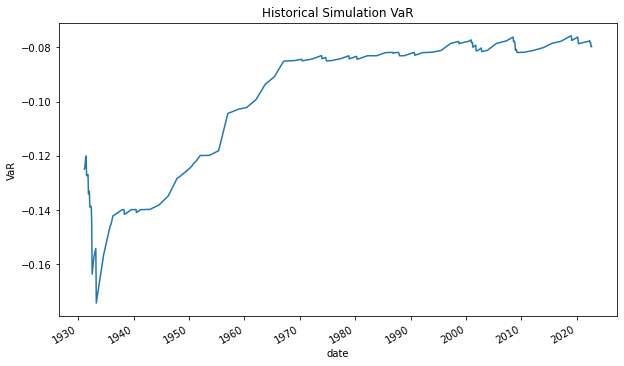

In [207]:
histsim_var = df['excess_return'].shift().expanding(min_periods = 60).quantile(.05)
histsim_var.plot(figsize = (10, 6), title = 'Historical Simulation VaR')
plt.ylabel('VaR')

In [208]:
#Frequency of periods for which r < r_var

#Number of days where excess return is less than VaR divided by total number of Days

frq = round(len(df[df['excess_return']<histsim_var])/len(histsim_var.dropna()),4)
print ("{:.2%}".format(frq))

3.03%


#### Drawbacks of historical var
- VaR is backward looking, as in, it only looks at historical data.
- VaR also places equal weightage on all observations, which is not ideal. This is due to the fact that historical data from long back is weigted equivalent to recent historical data.

## 2. Volatility

We will calculate a time-series of volatility estimates using a few different methods. For each, we use $ σ_t $ to denote our estimate of the time-t return volatility, as based on data over periods 1 (Jan 1926) through t − 1, but not including t itself.

- Expanding Series:
 $ \sigma ^{2}_{t,expanding}=\dfrac {1}{t-1}\sum ^{t-1}_{\tau =1}\tilde {r}^{2}_{\tau} $
- Begin the calculation at t = 61, so that the first estimate is based on 60 data points.
- Rolling Window:
 $ \sigma ^{2}_{t,rolling}=\dfrac {1}{m}\sum ^{m}_{l =1}\tilde {r}^{2}_{t-l} $
- Use m = 60, and begin the calculation at the t = 61, (so that the calculation has a full 60
data points.)

### (a) For each of these two methods, plot $ σ_t $. (Plot the vol, not the variance.)

In [209]:
vol = np.sqrt(pd.DataFrame((df['excess_return']**2).shift().expanding(min_periods=60).mean()))
vol['rolling_window'] = np.sqrt((df['excess_return']**2).shift().rolling(60).mean())

vol.rename(columns={"excess_return":"expanding_window"},inplace=True)
vol.dropna(inplace=True)
vol

,expanding_window,rolling_window
date,,
1931-01-31,0.0601,0.0601
1931-02-28,0.0601,0.0606
1931-03-31,0.0612,0.0621
1931-04-30,0.0614,0.0622
1931-05-29,0.0620,0.0632
...,...,...
2022-04-29,0.0546,0.0471
2022-05-31,0.0547,0.0484
2022-06-30,0.0546,0.0484


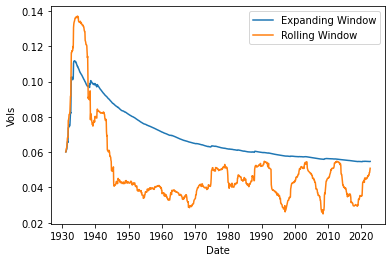

In [210]:
plt.plot(vol['expanding_window'], label = 'Expanding Window')
plt.plot(vol['rolling_window'], label = 'Rolling Window')
plt.xlabel("Date")
plt.ylabel("Vols")
plt.legend()

### (b) For each method, calculate the 5th percentile, 1-month-ahead VaR. We use a slight simplification of the normal VaR formula, by dropping μ from that formula, and rounding the normal distribution z-score to -1.65. 
$ \tilde{r}^{VaR,0.05}_{t,vol} = -1.65\sigma_{t} $

In [211]:
VaR = -1.65 * vol
VaR

,expanding_window,rolling_window
date,,
1931-01-31,-0.0992,-0.0992
1931-02-28,-0.0992,-0.1000
1931-03-31,-0.1010,-0.1024
1931-04-30,-0.1013,-0.1027
1931-05-29,-0.1023,-0.1043
...,...,...
2022-04-29,-0.0901,-0.0776
2022-05-31,-0.0902,-0.0798
2022-06-30,-0.0902,-0.0798


### (c) For each of these three vol-based VaR estimates, calculate the frequency of periods in which
$ \tilde{r}_t $ < $ \tilde{r}^{VaR,0.05}_{t,vol} $.

In [212]:
freq_df = pd.DataFrame(index = ['Frequency'], columns = VaR.columns)

for col in freq_df:
    freq_df[col] = len(VaR[df.loc[VaR.index, 'excess_return'] < VaR[col]]) / len(VaR[col].dropna().index)

freq_df['histsim_var'] = frq
   
round(freq_df, 4)

,expanding_window,rolling_window,histsim_var
Frequency,0.0175,0.0496,0.0303


### (d) Compare and contrast your results among each other and relative to the historic method in the previous problem

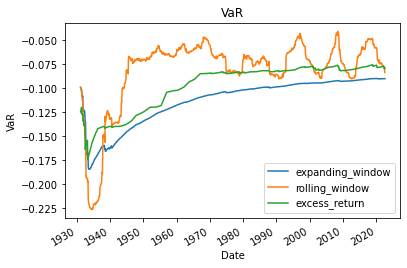

In [213]:
VaR.plot()
histsim_var.plot()
plt.title('VaR')
plt.ylabel('VaR')
plt.xlabel('Date')
plt.legend()

## 3. CVaR

Re-do the previous two problems, but this time calculating CVaR instead of VaR, (still for
q = .05.) That is, calculate CVaR for

- the empirical cdf
- the normal model, using expanding volatility estimates
- the normal model, using rolling volatility estimates

for dt in dates:
r = level_er.loc[:dt] #returns
vaR = df_v.loc[dt,vaR]
cvar = r[r['er] < var].mean()
df_v.loc[dt,cvar] = cvar

<AxesSubplot:title={'center':'CVAR'}, xlabel='date'>

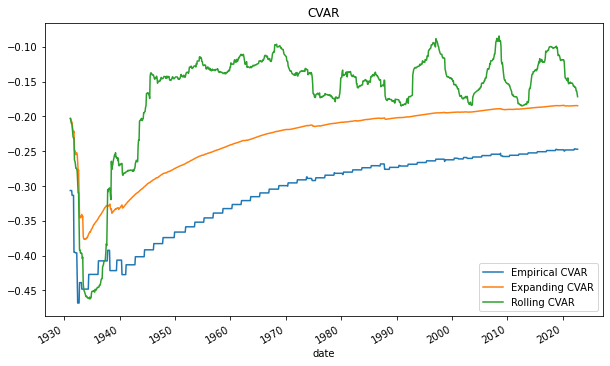

In [224]:

rolling_cvar = pd.DataFrame(index = df.index)
for date in VaR.index:
    tail_ret = df.loc[:date].dropna()
    cvar = tail_ret[tail_ret <= tail_ret.quantile(.05)].mean()
    rolling_cvar.loc[pd.to_datetime(date),'Empirical CVAR'] = cvar.values[2]


rolling_cvar['Expanding CVAR'] = VaR['expanding_window']
rolling_cvar['Rolling CVAR'] = VaR['rolling_window']

rolling_cvar = norm.pdf(1.65)/0.05 * rolling_cvar
rolling_cvar.plot(figsize = (10, 6), title = 'CVAR')

In [221]:
rolling_cvar.dropna()

,Empirical CVAR,Expanding CVAR,Rolling CVAR
date,,,
1931-01-31,-0.3066,-0.2029,-0.2029
1931-02-28,-0.3066,-0.2028,-0.2045
1931-03-31,-0.3066,-0.2066,-0.2094
1931-04-30,-0.3066,-0.2071,-0.2100
1931-05-29,-0.3134,-0.2092,-0.2133
...,...,...,...
2022-04-29,-0.2470,-0.1843,-0.1588
2022-05-31,-0.2470,-0.1845,-0.1633
2022-06-30,-0.2472,-0.1844,-0.1632


### Frequency of periods in which $ \tilde{r}_t $ < $ \tilde{r}^{CVaR,0.05}_{t,vol} $

In [219]:
freq_df = pd.DataFrame(index = ['Frequency'], columns = rolling_cvar.columns)

for col in freq_df:
    freq_df[col] = len(rolling_cvar[df.loc[rolling_cvar.index, 'excess_return'] < rolling_cvar[col]]) / len(rolling_cvar[col].dropna().index)

   
round(freq_df, 4)

,Empirical CVAR,Expanding CVAR,Rolling CVAR
Frequency,0.0,0.0018,0.0046


### Why is frequencty of Empirical CVAR = 0? Let's check the data

<AxesSubplot:title={'center':'CVAR'}, xlabel='date'>

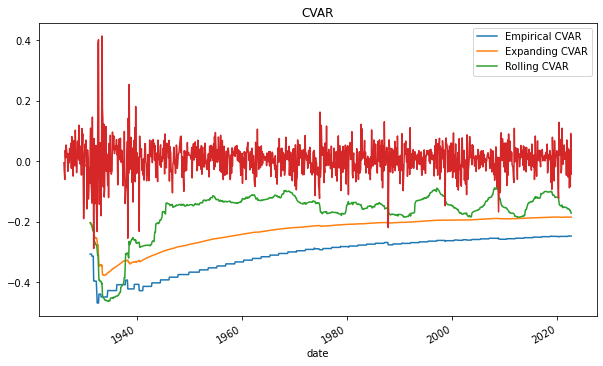

In [226]:
rolling_cvar.plot(figsize = (10, 6), title = 'CVAR')
df['excess_return'].plot()

- We note tat the excess returns are never falling below are empirical CVAR, hence the frequency is 0.

## 4. Extra

For the VaR calculations of Problem 2.2, and 2.3 try using the following models to estimate volatility:
- Exponentially Weighted Moving Average (EWMA)
- $ \sigma ^{2}_{t,EWMA}=\theta  {\sigma}^{2}_{t-1,EWMA}+(1-\theta)\tilde{r} ^{2}_{t-1} $
- 

Rather than estimating $\theta$, simply use $\theta$ = 0.97, and initialize with $ \sigma_{1} $ = 0.15.
- GARCH(1,1) model.
- To estimate GARCH(1,1), try using the ARCH package in Python. The default estimation implementation is fine.
- You should be familiar with EWMA and GARCH from the August Review.

### EWMA

In [ ]:
IGARCH = arch_model(df['excess_return'])
theta = 0.97

IGARCH.volatility = EWMAVariance(theta)

IGARCH_model = IGARCH.fit()

IGARCH_model.params

Iteration:      1,   Func. Count:      3,   Neg. LLF: 3984570.5364937778
Iteration:      2,   Func. Count:     10,   Neg. LLF: -1858.8039187809004
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1858.8039187817976
            Iterations: 2
            Function evaluations: 10
            Gradient evaluations: 2


mu    0.007
Name: params, dtype: float64

### GARCH

In [ ]:
GARCH = arch_model(df['excess_return'], vol='Garch', p=1, o=0, q=1, dist='Normal')

GARCH_model = GARCH.fit()

GARCH_model.params

Iteration:      1,   Func. Count:      6,   Neg. LLF: 38084950.95967265
Iteration:      2,   Func. Count:     16,   Neg. LLF: -1909.9199599735189
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1909.9199630529993
            Iterations: 6
            Function evaluations: 16
            Gradient evaluations: 2


mu          7.8426e-03
omega       5.8962e-05
alpha[1]    1.0000e-01
beta[1]     8.8000e-01
Name: params, dtype: float64

Text(0.5, 1.0, 'Volatility Estimates')

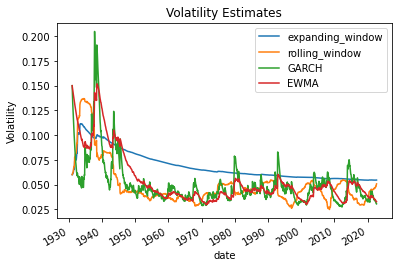

In [ ]:
vol[['GARCH','EWMA']] = None

vol.iloc[0,2:] = 0.15

for i in range(1, len(vol)):
    vol['EWMA'].iloc[i] = np.sqrt((vol['EWMA'].iloc[i-1]**2) * theta + (1-theta) * df['excess_return'].iloc[i-1]**2)
    vol['GARCH'].iloc[i] = np.sqrt(GARCH_model.params['omega'] + GARCH_model.params['alpha[1]'] * df['excess_return'].iloc[i-1]**2 + GARCH_model.params['beta[1]'] * vol['GARCH'].iloc[i-1]**2)
    
vol.dropna(inplace=True)

vol.plot()
plt.ylabel('Volatility')
plt.title('Volatility Estimates')

In [ ]:
VaR = -1.65 * vol
VaR.head()

,expanding_window,rolling_window,GARCH,EWMA
date,,,,
1931-01-31,-0.0992,-0.0992,-0.2475,-0.2475
1931-02-28,-0.0992,-0.1000,-0.2325,-0.2438
1931-03-31,-0.1010,-0.1024,-0.2193,-0.2403
1931-04-30,-0.1013,-0.1027,-0.2085,-0.2373
1931-05-29,-0.1023,-0.1043,-0.1969,-0.2339


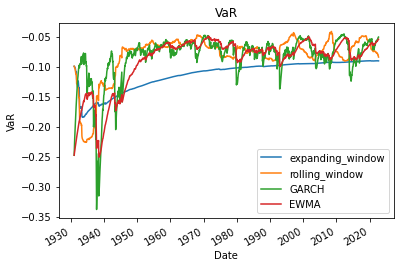

In [ ]:
VaR.plot()

plt.title('VaR')
plt.ylabel('VaR')
plt.xlabel('Date')
plt.show()

In [ ]:
freq_df = pd.DataFrame(index = ['Frequency'], columns = VaR.columns)

for col in freq_df:
    freq_df[col] = len(VaR[df.loc[VaR.index, 'excess_return'] < VaR[col]]) / len(VaR[col].dropna().index)
    
round(freq_df, 4)

,expanding_window,rolling_window,GARCH,EWMA
Frequency,0.0175,0.0496,0.0524,0.0469


## 3 Estimating Underperformance


Use the returns on the S&P 500 (rM ) and 1-month T-bills, (rf ) provided in “barnstable analysis data.xlsx”.
Barnstable’s estimates of mean and volatility are based on the subsample of 1965 to 1999. We consider this subsample, as well as 2000-2022, as well as the full sample of 1926-2022. We only have data through August of 2022, but no adjustment is needed for the fact that you have only the partial year–just use what you have.

### 1. SUMMARY STATISTICS

#### (a) Report the following (annualized) statistics.

In [ ]:
log_df = np.log(1+df)
log_df.head(5)

,SPX,TB1M,excess_return
date,,,
1926-01-30,-0.0018,0.0031,-0.0049
1926-02-27,-0.0339,0.0026,-0.0366
1926-03-31,-0.0594,0.0026,-0.0622
1926-04-30,0.0378,0.0023,0.0356
1926-05-28,0.0135,0.0027,0.0109


In [238]:
def annualized_stats(data, annual_factor, log = False):
    if log == False:
        df = pd.DataFrame(data = None, 
                          index = [r'$r^{M}$',r'${\tilde{r}^{M}}$',r'$r^{f}$'])
    else: 
        df = pd.DataFrame(data = None, 
                      index = [r'log $r^{M}$',r'log ${\tilde{r}^{M}}$',r'log $r^{f}$'])
        
    df[str(data.index[0].year) + '-' + str(data.index[-1].year) + r' $\mu$'] = [data['SPX'].mean(),
                                                                                data['SPX'].mean()-data['TB1M'].mean(),
                                                                                data['TB1M'].mean()] 
    
    df[str(data.index[0].year) + '-' + str(data.index[-1].year) + r' $\mu$'] *= annual_factor
    
    df[str(data.index[0].year) + '-' + str(data.index[-1].year) + r' $\sigma$'] = [data['SPX'].std(),
                                                                                   (data['SPX']-data['TB1M']).std(),
                                                                                   data['TB1M'].std()] 
    
    df[str(data.index[0].year) + '-' + str(data.index[-1].year) + r' $\sigma$'] *= np.sqrt(annual_factor)
    
    return df

def join(df_list):
    df = df_list[0]
    
    for df_ in df_list[1:]:
        df = df.join(df_)
    
    return df

stats_ = join([annualized_stats(df.loc['1965':'1999'], 12),
             annualized_stats(df.loc['2000':], 12),
             annualized_stats(df.loc['1926':], 12),
             annualized_stats(df.loc['1965':], 12)])

log_stats = join([annualized_stats(log_df.loc['1965':'1999'], 12, log = True),
                 annualized_stats(log_df.loc['2000':], 12, log = True),
                 annualized_stats(log_df.loc['1926':], 12, log = True),
                 annualized_stats(log_df.loc['1965':], 12, log = True)])

stats_df = stats_.append(log_stats)
stats_df

,1965-1999 $\mu$,1965-1999 $\sigma$,2000-2022 $\mu$,2000-2022 $\sigma$,1926-2022 $\mu$,1926-2022 $\sigma$,1965-2022 $\mu$,1965-2022 $\sigma$
$r^{M}$,0.1302,0.1495,0.0759,0.1526,0.1132,0.1878,0.1088,0.1508
${\tilde{r}^{M}}$,0.0687,0.1502,0.0616,0.1531,0.0816,0.1881,0.0659,0.1513
$r^{f}$,0.0615,0.0072,0.0143,0.0050,0.0315,0.0086,0.0429,0.0092
log $r^{M}$,0.1184,0.1497,0.0640,0.1537,0.0953,0.1871,0.0970,0.1513
log ${\tilde{r}^{M}}$,0.0571,0.1504,0.0497,0.1542,0.0638,0.1873,0.0542,0.1518
log $r^{f}$,0.0613,0.0071,0.0143,0.0050,0.0315,0.0085,0.0428,0.0092


#### (b) Comment on how the full-sample return stats compare to the sub-sample stats.Comment on how the level stats compare to the log stats.

- Log returns are lower in mean compared to level returns. This is because log returns are additive, while level returns are multiplicative. This means that log returns are more stable, and have a lower mean.
- The earlier subsample has a much higher mean returns, but similar excess returns due to the notable decrease in $r^f$.

### 2. Calculate the probability that the cumulative market return will fall short of the cumulative risk-free return.

$ Pr[R^{M}_{t,t+h} < R^{f}_{t,t+h}] $ ....(1)

#### To analyze this analytically, convert the probability statement above to a probability statement about mean log returns.
#### (a) Calculate (1) using the subsample 1965-1999.

In [ ]:
def prob_calc(h, tilde_mu, tilde_sigma):
    return stats.norm.cdf(- np.sqrt(h) * tilde_mu / tilde_sigma)

def prob(h, tilde_mu, tilde_sigma):
    prob_df = pd.DataFrame(data = h, columns = ['h'])
    
    prob_df['Probability'] = prob_calc(prob_df['h'], tilde_mu, tilde_sigma)
    
    prob_df = prob_df.set_index('h')
    
    return prob_df

In [248]:
mu_tilde = stats_df.iloc[4,0]
sigma_tilde = stats_df.iloc[4,1]
h = 2022 - 2000 +1 #Using subsample of 1965-1999 to predict 2022

prob([h], mu_tilde, sigma_tilde)


,Probability
h,
23,0.0344


#### (b) Report the precise probability for h = 15 and h = 30 years.

In [ ]:
prob(list(range(10,35,5)), mu_tilde, sigma_tilde)

,Probability
h,
10,0.1151
15,0.0708
20,0.0449
25,0.0289
30,0.0188


#### (c) Plot the probability as a function of the investment horizon, h, for 0 < h ≤ 30 years.

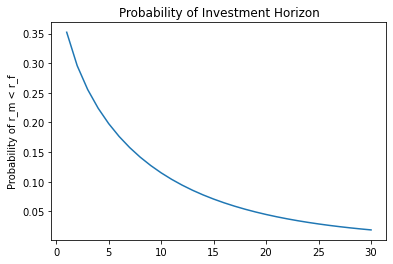

In [ ]:
def prob_plot(h, tilde_mu, tilde_sigma):
    prob_horizon = prob(h, tilde_mu, tilde_sigma)
    plt.plot(prob_horizon.index, prob_horizon['Probability'])
    plt.title('Probability of Investment Horizon')
    plt.ylabel('Probability of r_m < r_f')
    plt.show()

prob_plot(list(range(1,31)), mu_tilde, sigma_tilde)

### 3. Use the sample 1965-2022 to reconsider the 30-year probability. As of the end of 2022, calculate the probability of the stock return underperforming the risk-free rate over the next 30 years. That is, RM underperforming Rf for 0 < h ≤ 30.

<AxesSubplot:xlabel='h'>

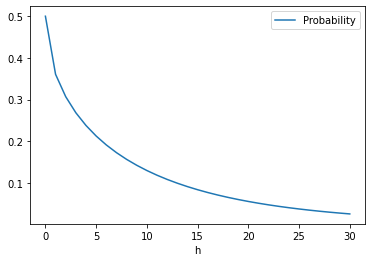

In [241]:
mu_tilde = stats_df.iloc[4,6]
sigma_tilde = stats_df.iloc[4,7]

prob(list(range(0,31)), mu_tilde, sigma_tilde).plot()

### 4 Let’s consider how things turned out relative to Barnstable’s 1999 expectations

#### a. What was the probability (based on the 1999 estimate of μ,) that the 23-year market return,$ R^{M}_{t,t+23} $ , would be smaller than that realized in 2000-2022? Note that we are asking about the market return, not the excess market return. Continue using the 1965-1999 sample standard deviation for σ.

In [242]:
stats_df

,1965-1999 $\mu$,1965-1999 $\sigma$,2000-2022 $\mu$,2000-2022 $\sigma$,1926-2022 $\mu$,1926-2022 $\sigma$,1965-2022 $\mu$,1965-2022 $\sigma$
$r^{M}$,0.1302,0.1495,0.0759,0.1526,0.1132,0.1878,0.1088,0.1508
${\tilde{r}^{M}}$,0.0687,0.1502,0.0616,0.1531,0.0816,0.1881,0.0659,0.1513
$r^{f}$,0.0615,0.0072,0.0143,0.0050,0.0315,0.0086,0.0429,0.0092
log $r^{M}$,0.1184,0.1497,0.0640,0.1537,0.0953,0.1871,0.0970,0.1513
log ${\tilde{r}^{M}}$,0.0571,0.1504,0.0497,0.1542,0.0638,0.1873,0.0542,0.1518
log $r^{f}$,0.0613,0.0071,0.0143,0.0050,0.0315,0.0085,0.0428,0.0092


In [249]:
mu_bar = stats_df.iloc[3,0] - stats_df.iloc[3,2]
sigma = stats_df.iloc[3,1]
h = 2022-2000+1
prob([23], mu_bar, sigma)

,Probability
h,
23,0.0408


#### (b) Suppose Barnstable had implemented the put-option strategy with the growing strike of 6%? Based on the 2000-2022 performance, what is the probability that the 2000-2029 cumulative market return will be low enough to make the puts in the money? For the calculation, update your estimates of μ, σ to be the estimates based on 1965-2022.

In [254]:
strike = np.log(1+0.06)

mu65 = stats_df.iloc[3,6]

sigma65 = stats_df.iloc[3,7]

mu = 23/7 * (stats_df.iloc[3, 2] - strike) + mu65 - strike

prob([7], mu, sigma65)

,Probability
h,
7,0.1567
